In [51]:
import os, glob, random, time, gc
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import h5py
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [52]:
ROOT_EXP = f'output/V*/*'

PATHS_EXP = glob.glob(ROOT_EXP)
PATHS_EXP[:4]

['output/V16/A100_V16_CALFalseDEFTrueNONTrue_hrnet_w30BC16TH0.3_R-RPM_R-RPM_fl-tr_WD1e-05E15GA1CE-W1UP8BETA0.25R0.1MIX0.5FREE12B16_Scr',
 'output/V64/A100_V64_CALFalseDEFTrueNONTrue_hrnet_w30BC16TH0.3_R-RPM_R-RPM_fl-tr_WD1e-05E10GA1CE-W1UP16BETA0.25R0.5MIX0.5FREE8B16_Scr',
 'output/V10/3090_V10_CALFalseDEFTrueNONFalse_hrnet_w30BC16TH0.3_R-RPM_R-RPM_fl-tr-gbr_WD0.001E200BETA0.25MIX0.5B16',
 'output/V5/A6000_V5_CALFalseDEFFalseNONFalse_hrnet_w30BC16TH0.4p1-99_LR0.001T0200MIX0.5B32_fl-tr']

In [53]:
df_cv = []

for i, PATH_EXP in enumerate(PATHS_EXP):
    dfs = []
    
    PATHS_OOF = glob.glob(f'{PATH_EXP}/*/inference/oof_*.csv')
    
    if len(PATHS_OOF) <  1:
        print(f'ERROR: {PATH_EXP} has {len(PATHS_OOF)} oof files')
        continue
    
    for PATH_OOF in PATHS_OOF:
        df = pd.read_csv(PATH_OOF)
        dfs.append(df)
        
    df_oof = pd.concat(dfs, axis=0)
    df_oof['iou_oof_mean'] = df_oof['iou'].mean()
    df_oof['exp'] = PATH_EXP.split('/')[-1]
    df_oof['version'] = PATH_EXP.split('/')[-2]
    df_cv.append(df_oof)
    
df_cv = pd.concat(df_cv, axis=0)
df_cv.head(4)
    

ERROR: output/V5/artifact has 0 oof files
ERROR: output/V6/inference_analysis has 0 oof files
ERROR: output/V6/A6000_V6_CALfullDEFFalseNONTrue_hrnet_w30BC32TH0.4_LR0.0001T0200BETA0.25MIX0.5B32 has 0 oof files
ERROR: output/V6/artifact has 0 oof files
ERROR: output/V9/inference_analysis has 0 oof files
ERROR: output/V9/artifact has 0 oof files
ERROR: output/V19/inference_analysis has 0 oof files
ERROR: output/V2/artifact has 0 oof files
ERROR: output/V3/artifact has 0 oof files
ERROR: output/V15/A100_V15_CALFalseDEFTrueNONTrue_hrnet_w30BC16TH0.3_R-RPM_fl-tr_0.0001_E20CE-W1UP1BETA0.5R0.5MIX0.5FREE16B32_Scr has 0 oof files
ERROR: output/V15/A6000_V15_CALFalseDEFFalseNONTrue_hrnet_w30BC16TH0.3_R-RPM_fl-tr_0.01_E20CE-W1UP2BETA0.25R0.5MIX0.5FREE16B32_Scr has 0 oof files
ERROR: output/V1/artifact has 0 oof files
ERROR: output/V1/DEBUG has 0 oof files
ERROR: output/V7/inference_analysis has 0 oof files
ERROR: output/V7/artifact has 0 oof files
ERROR: output/V13/A6000_V13_CALFalseDEFTrueNONTrue

,name,feature,mask,defects,fold,hight,width,california,pre_missing,post_missing,...,recall,f1,iou,threshold,positive,positive_ratio,iou_oof_mean,exp,version,state
0,0d30a00f-208f-4c9e-9aed-676527463854_1,../data/002_Full+California/img/0d30a00f-208f-...,../data/002_Full+California/ann/0d30a00f-208f-...,False,2,512,512,False,False,False,...,0.000000,0.000000,0.000000,1.45000,True,0.000153,0.516552,A100_V16_CALFalseDEFTrueNONTrue_hrnet_w30BC16T...,V16,NaN
1,0ff249de-784d-4760-a039-ed9f92eca60c_0,../data/002_Full+California/img/0ff249de-784d-...,../data/002_Full+California/ann/0ff249de-784d-...,False,0,512,512,False,False,False,...,0.643173,0.355911,0.234191,0.08289,True,0.017262,0.516552,A100_V16_CALFalseDEFTrueNONTrue_hrnet_w30BC16T...,V16,NaN
2,0ff249de-784d-4760-a039-ed9f92eca60c_1,../data/002_Full+California/img/0ff249de-784d-...,../data/002_Full+California/ann/0ff249de-784d-...,False,0,512,512,False,False,False,...,0.751629,0.839341,0.766507,0.06666,True,0.242329,0.516552,A100_V16_CALFalseDEFTrueNONTrue_hrnet_w30BC16T...,V16,NaN
3,102ad46e-a89c-4656-bee0-2d6ef4fdaa8d_1,../data/002_Full+California/img/102ad46e-a89c-...,../data/002_Full+California/ann/102ad46e-a89c-...,False,3,512,512,False,False,False,...,0.000000,0.000000,0.000000,1.45000,True,0.000309,0.516552,A100_V16_CALFalseDEFTrueNONTrue_hrnet_w30BC16T...,V16,NaN


In [54]:
df_cv.shape

(26176, 32)

In [55]:
df_cv.columns

Index(['name', 'feature', 'mask', 'defects', 'fold', 'hight', 'width',
       'california', 'pre_missing', 'post_missing', 'ratio', 'cv', 'area',
       'h_idx', 'w_idx', 'remove', 'search_idx', 'same_idx', 'tp', 'fp', 'fn',
       'precision', 'recall', 'f1', 'iou', 'threshold', 'positive',
       'positive_ratio', 'iou_oof_mean', 'exp', 'version', 'state'],
      dtype='object')

In [56]:
df_cv['iou_mean'] = df_cv.groupby('exp')['iou'].transform('mean')
df_cv = df_cv.sort_values('iou_mean', ascending=False)
df_cv.head(4)

,name,feature,mask,defects,fold,hight,width,california,pre_missing,post_missing,...,f1,iou,threshold,positive,positive_ratio,iou_oof_mean,exp,version,state,iou_mean
37,96e09f95-a771-4409-a2ae-49df8eaeed6a_4,../data/002_Full+California/img/96e09f95-a771-...,../data/002_Full+California/ann/96e09f95-a771-...,False,2,512,512,False,True,False,...,0.966658,1.070004,0.254296,True,0.032047,0.547668,A100_V17_CALFalseDEFFalseNONTrue_hrnet_w30BC16...,V17,post,0.547668
34,6b5dd559-fca5-40d7-b2ef-6a92de31babf_0,../data/002_Full+California/img/6b5dd559-fca5-...,../data/002_Full+California/ann/6b5dd559-fca5-...,False,3,512,512,False,False,False,...,0.712594,0.376691,0.331782,True,0.002396,0.547668,A100_V17_CALFalseDEFFalseNONTrue_hrnet_w30BC16...,V17,post,0.547668
26,46705f46-b244-4e09-bcea-18ff46e133db_0,../data/002_Full+California/img/46705f46-b244-...,../data/002_Full+California/ann/46705f46-b244-...,False,4,512,512,False,False,False,...,0.000000,0.000000,1.450000,True,0.000549,0.547668,A100_V17_CALFalseDEFFalseNONTrue_hrnet_w30BC16...,V17,post,0.547668
27,4cdaac91-4a11-42aa-b704-597eac54cbd5_1,../data/002_Full+California/img/4cdaac91-4a11-...,../data/002_Full+California/ann/4cdaac91-4a11-...,False,2,512,512,False,False,False,...,0.890399,0.924947,0.064413,True,0.020466,0.547668,A100_V17_CALFalseDEFFalseNONTrue_hrnet_w30BC16...,V17,post,0.547668


In [57]:
df_cv = df_cv[df_cv['iou_mean'] > 0.3]

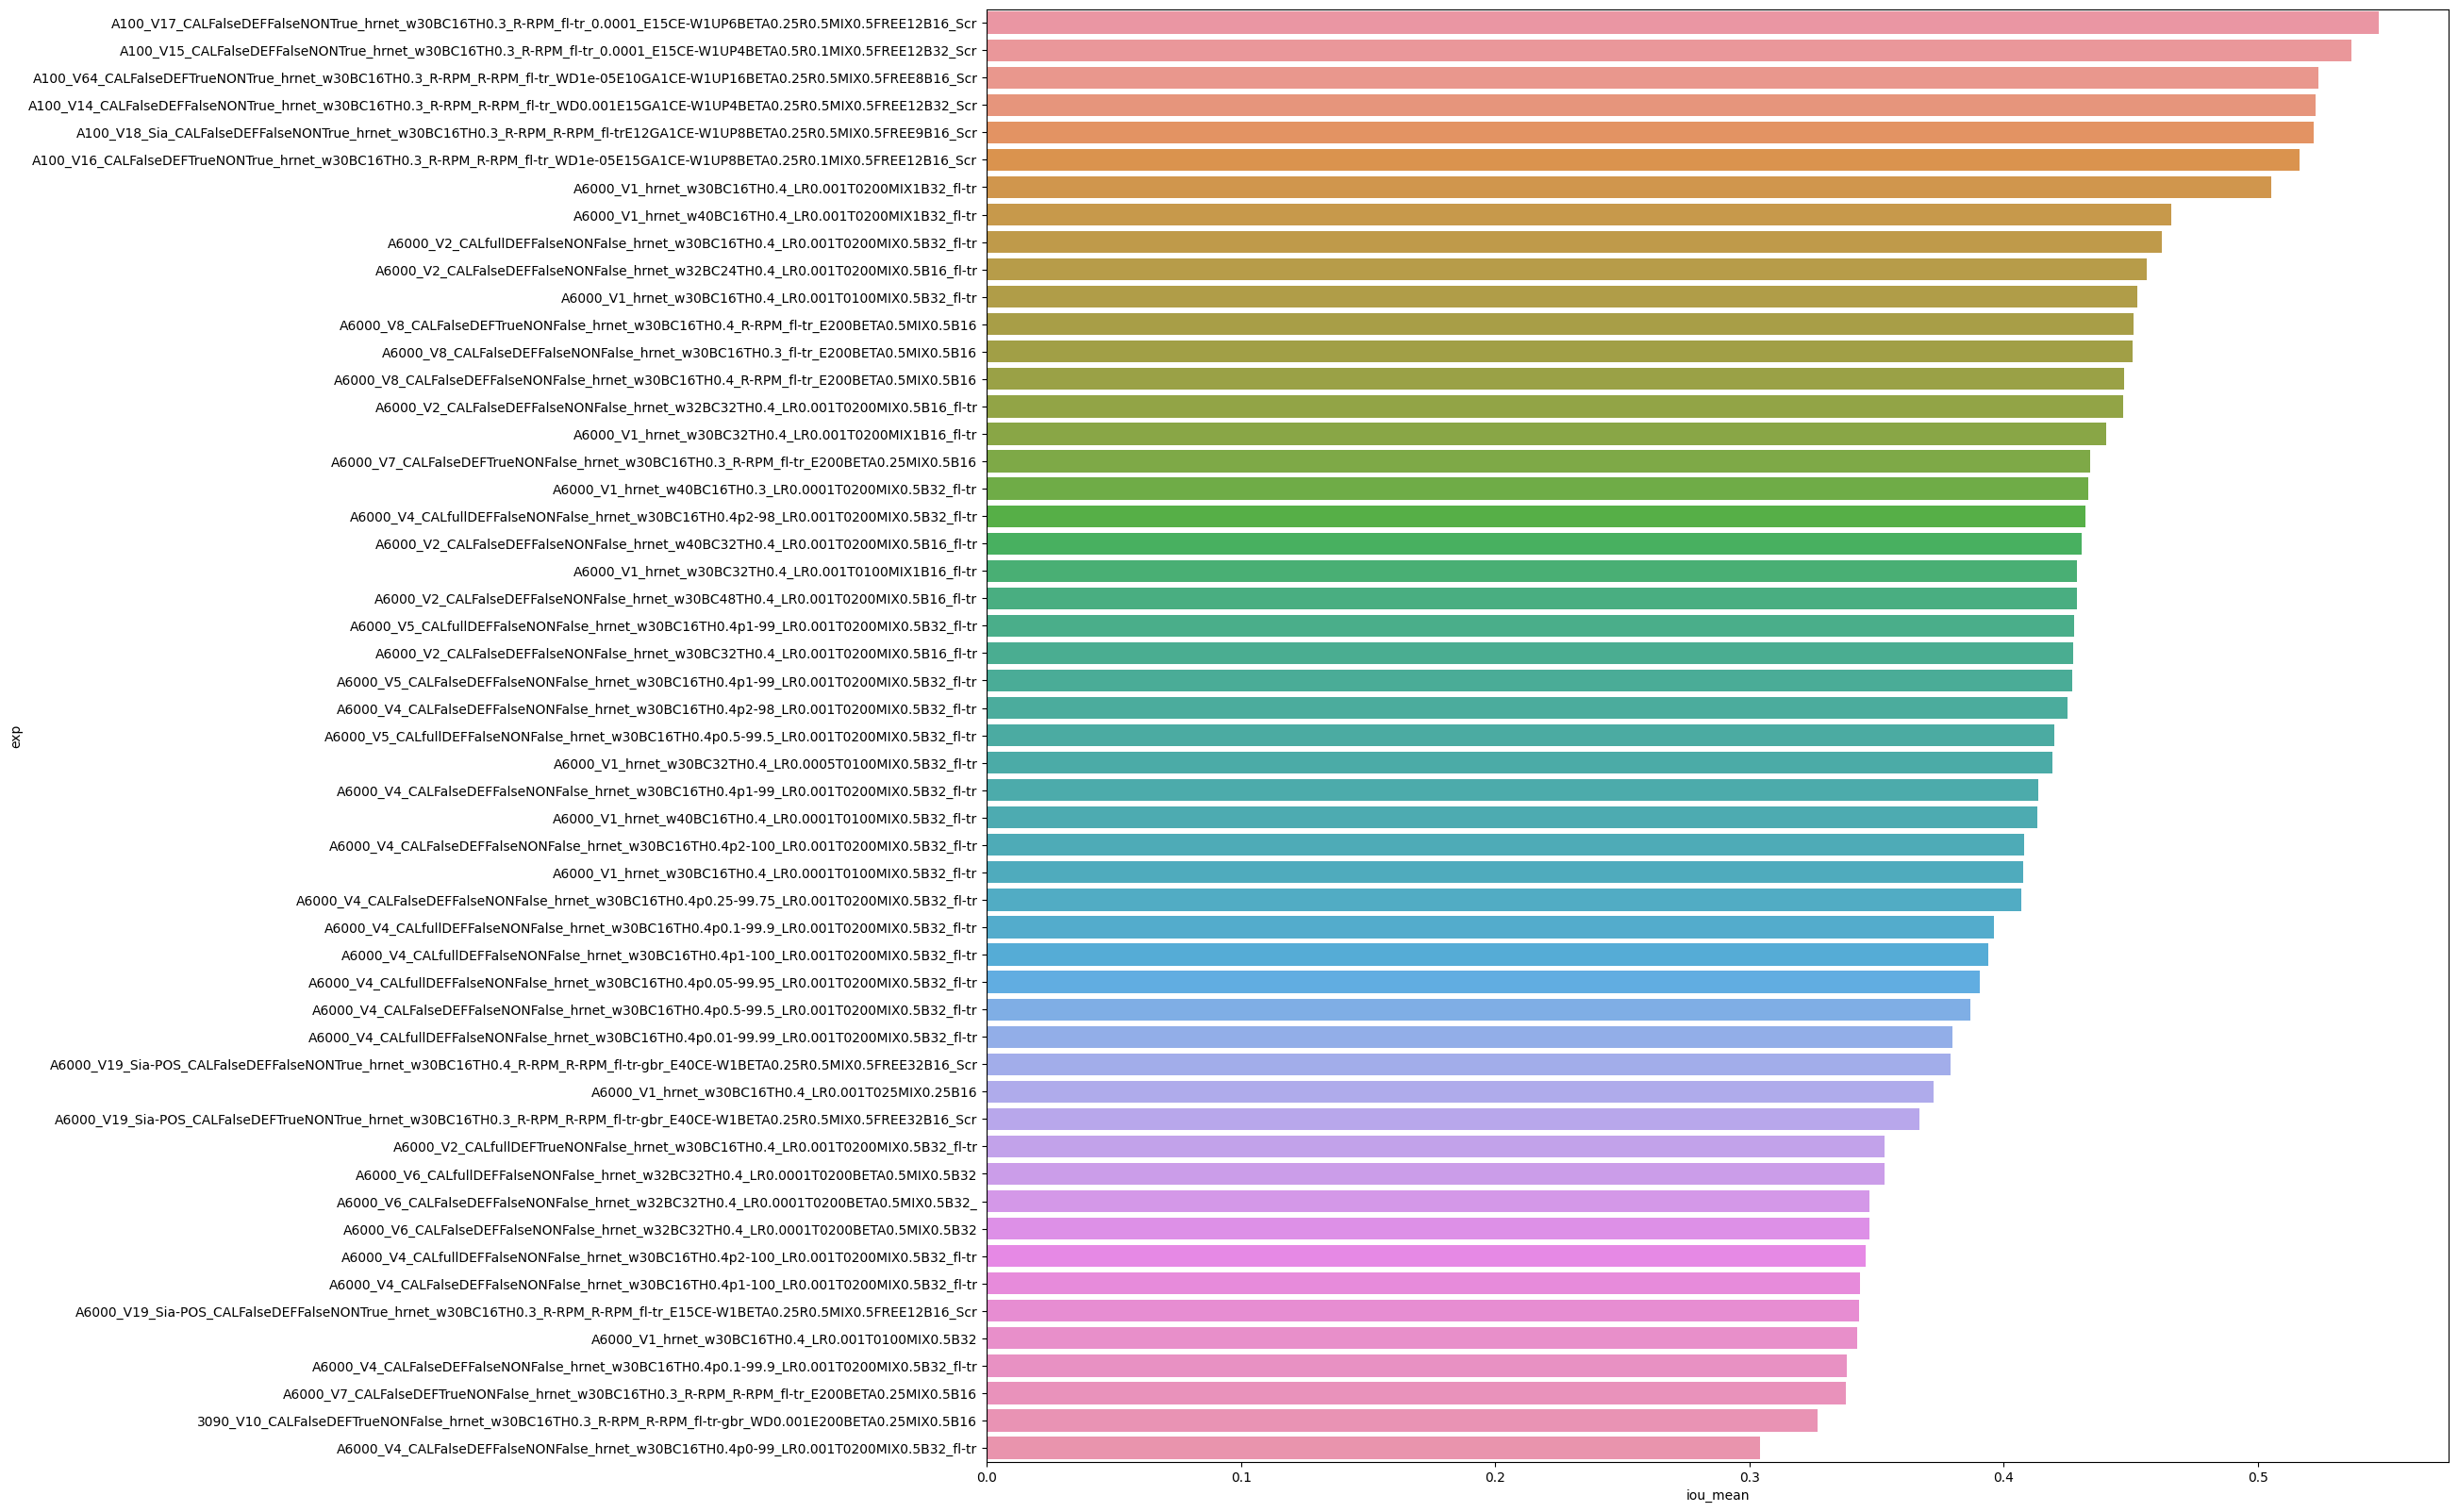

In [58]:
plt.figure(figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(data=df_cv, y="exp", x="iou_mean")
plt.savefig('output/analysis/fig_cv_analysis.png')
plt.show();

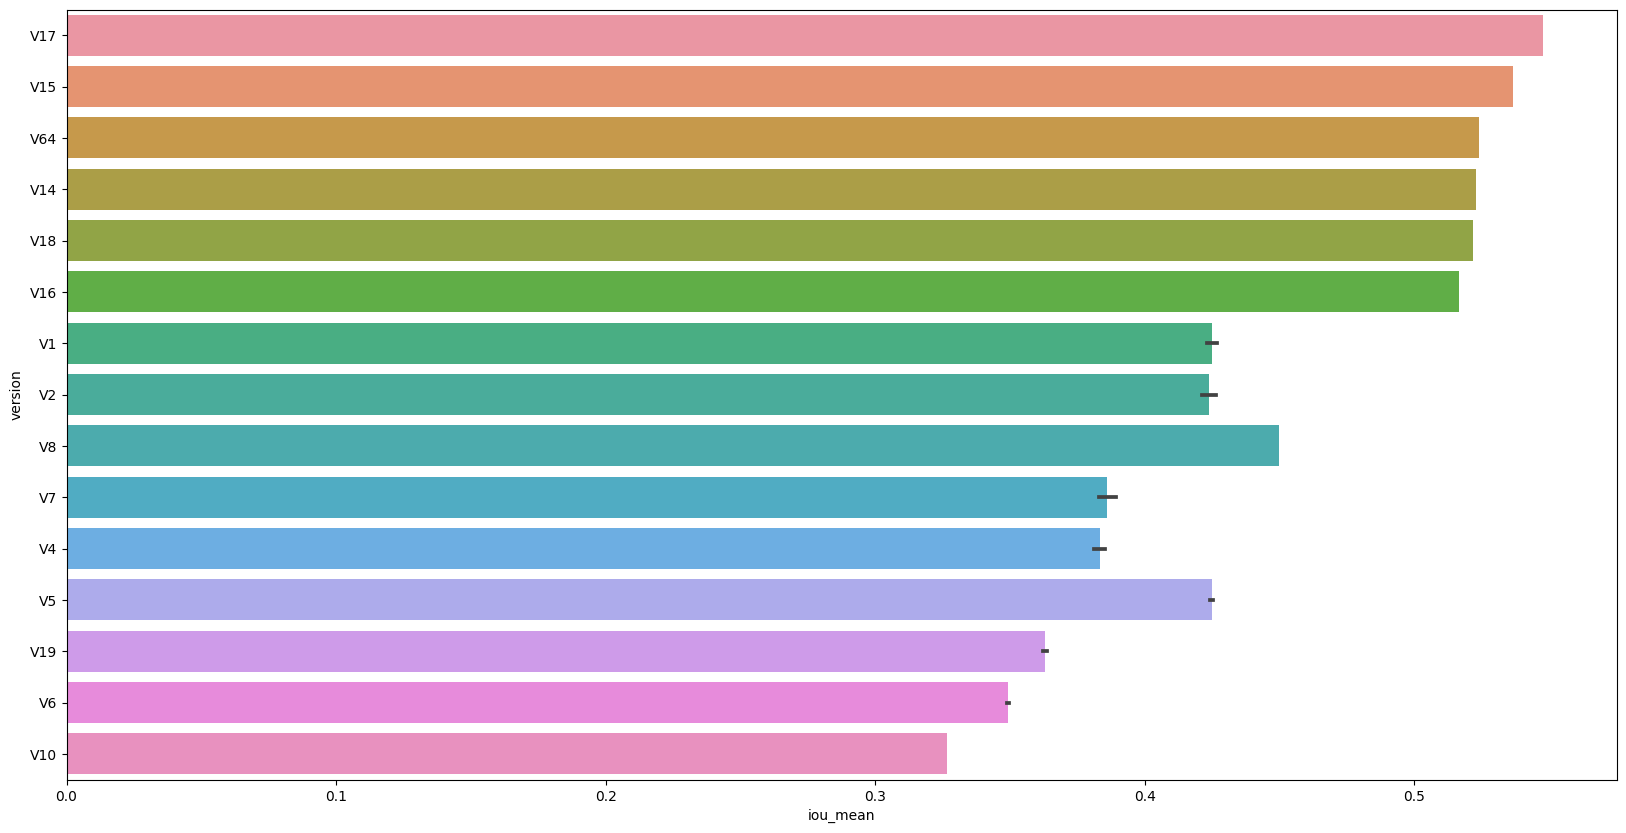

In [59]:
plt.figure(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(data=df_cv, y="version", x="iou_mean")
plt.savefig('output/analysis/fig_version_analysis.png')
plt.show();

In [60]:
df_cv = df_cv[df_cv['iou_mean'] > 0.5]

<Figure size 2000x1000 with 0 Axes>

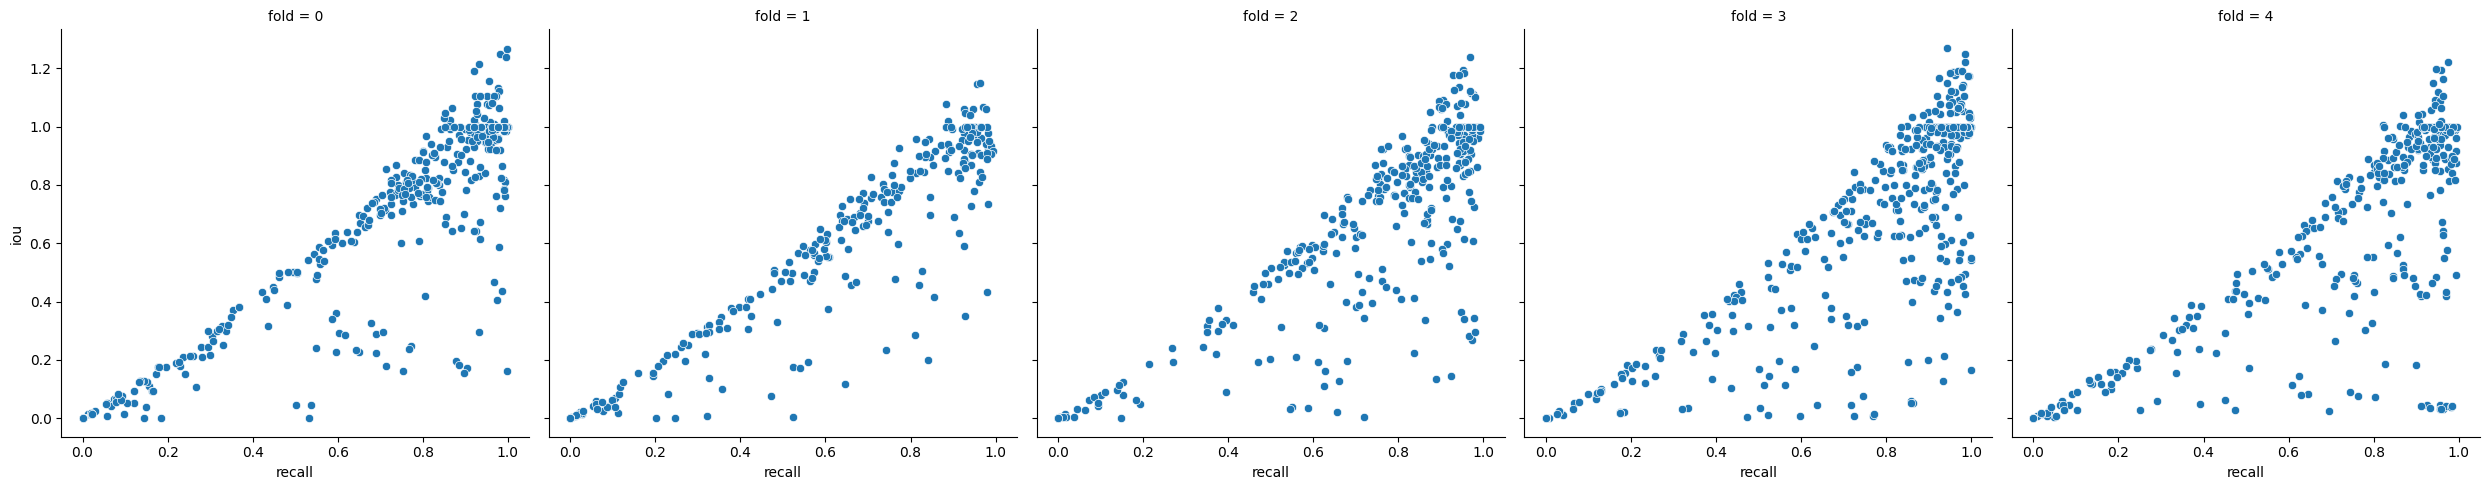

In [61]:
plt.figure(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
sns.relplot(data=df_cv, y="iou", x="recall", col="fold")

<Figure size 2000x1000 with 0 Axes>

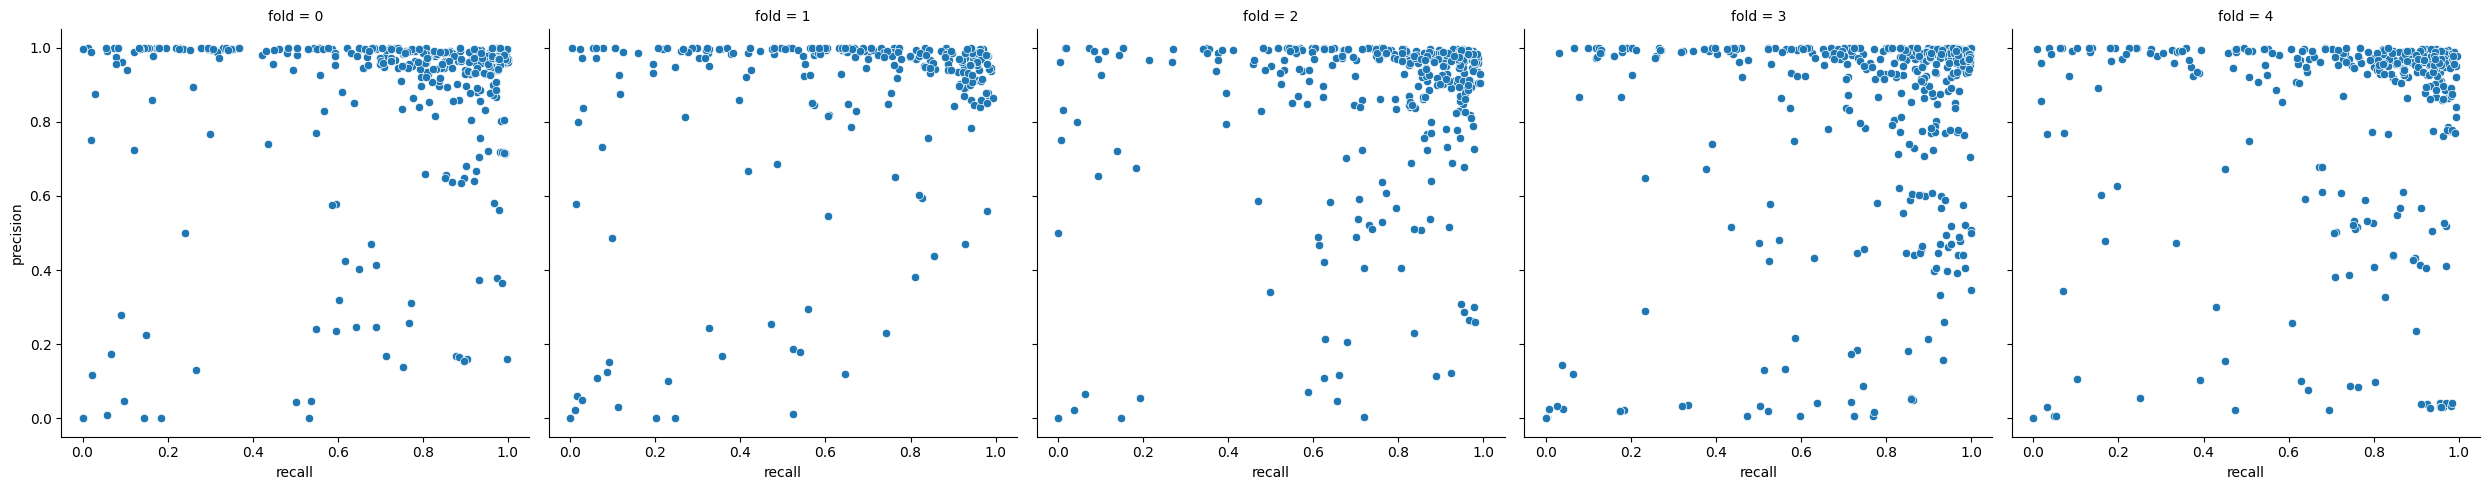

In [62]:
plt.figure(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
sns.relplot(data=df_cv, y="precision", x="recall", col="fold")

<Figure size 2000x1000 with 0 Axes>

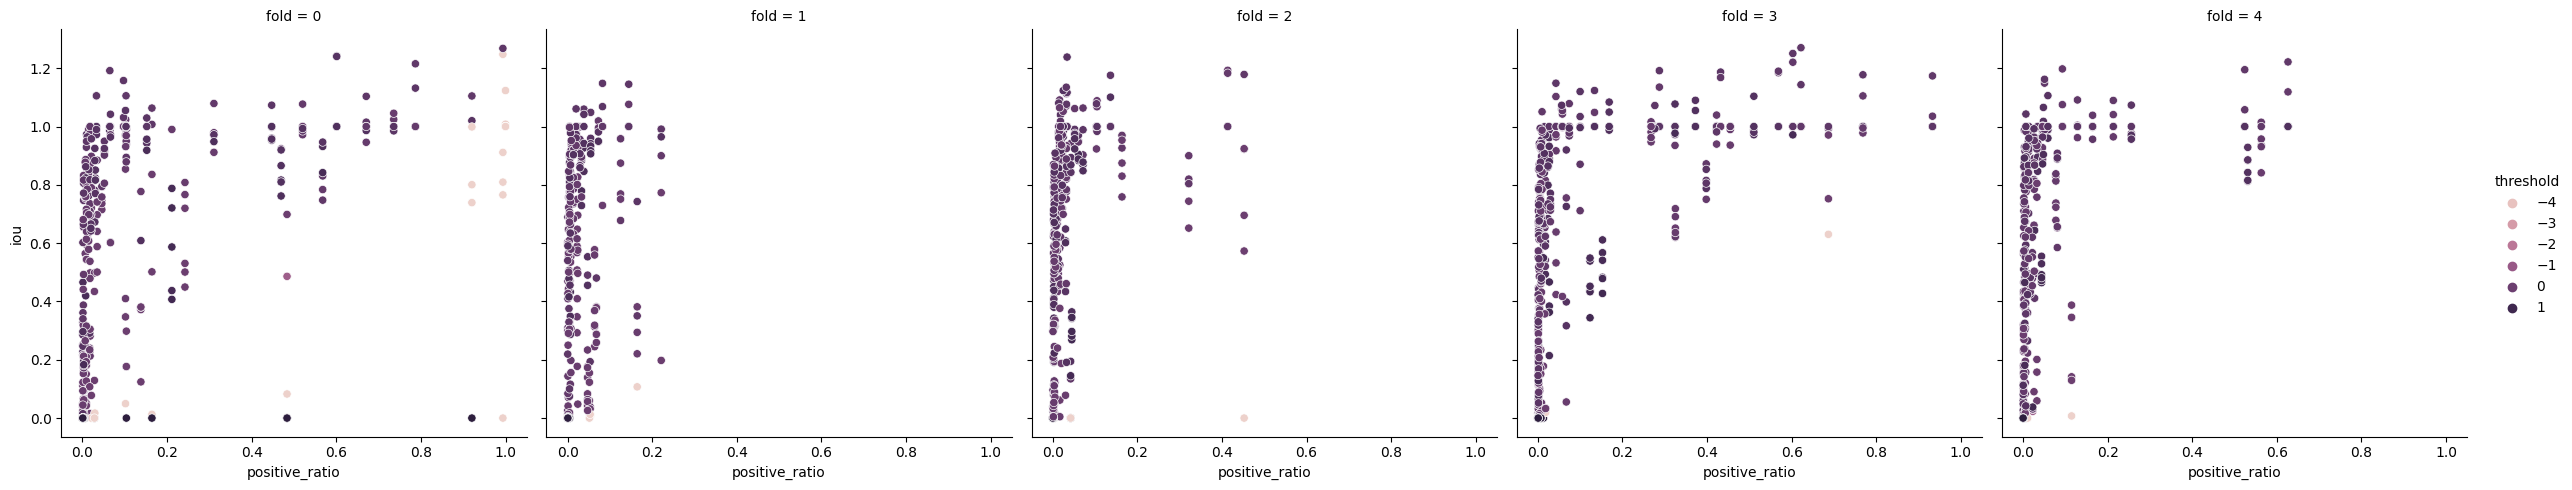

In [63]:
plt.figure(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
sns.relplot(data=df_cv, y="iou", x="positive_ratio", hue='threshold', col="fold")

<Figure size 2000x1000 with 0 Axes>

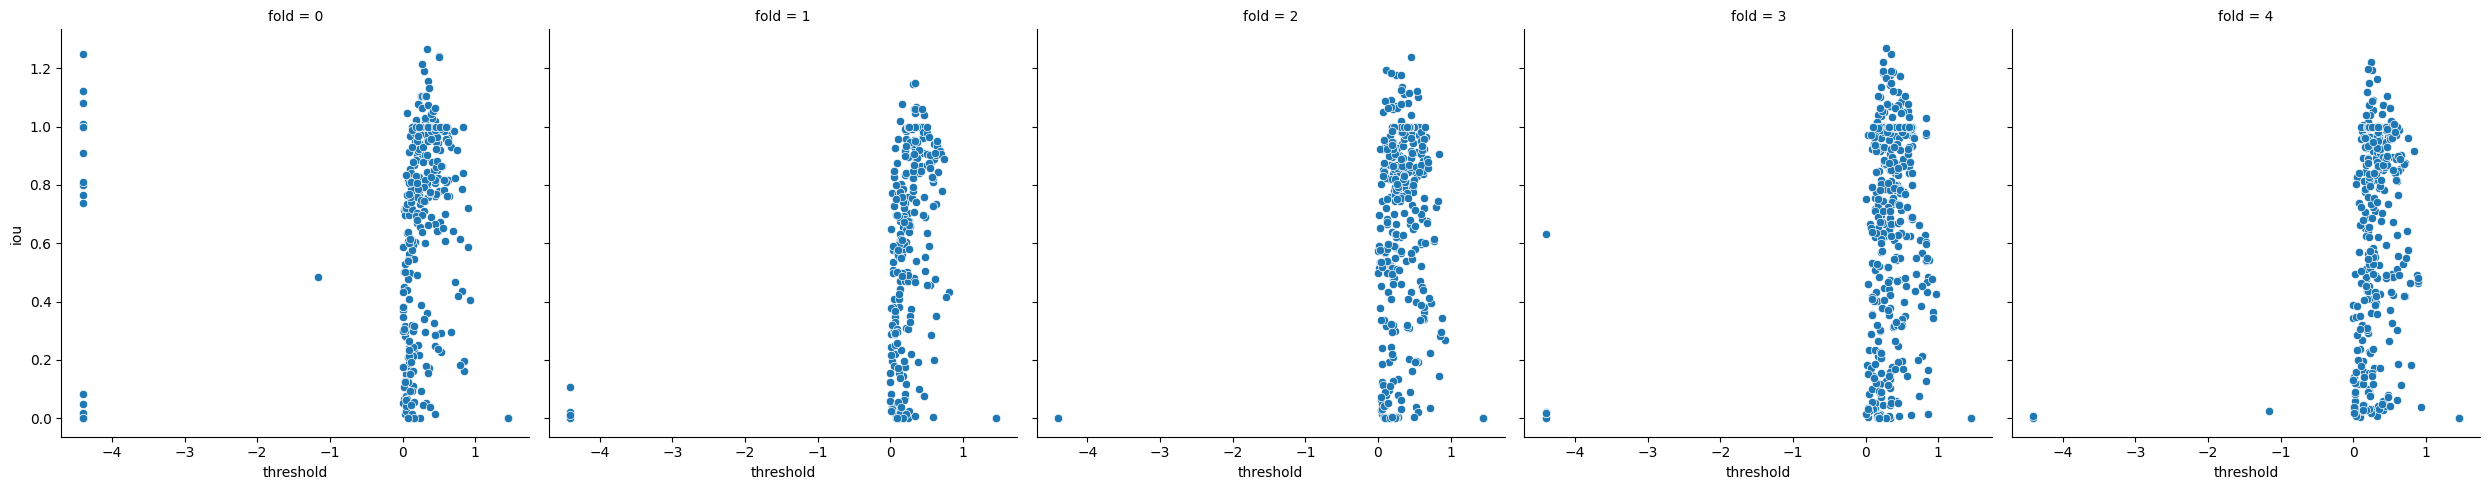

In [64]:
plt.figure(figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
sns.relplot(data=df_cv, y="iou", x='threshold', col="fold")

In [65]:
df_cv[df_cv['threshold'] > 0.]['threshold'].mean()

0.5542459924104105